In [1]:
import pandas as pd


In [38]:
file_path = 'phewa.csv'
df = pd.read_csv(file_path)
df.head()

,YEAR,MO,DY,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN
0,1981,2,1,10.08,2.50,6.29,8.88,9.01,14.97,5.96
1,1981,2,2,9.66,-0.03,4.82,7.75,10.43,16.03,5.60
2,1981,2,3,10.21,0.23,5.22,7.83,10.34,16.69,6.35
3,1981,2,4,11.92,2.11,7.01,9.43,11.78,18.75,6.98
4,1981,2,5,14.65,2.92,8.79,11.88,14.33,22.75,8.42


In [39]:
selected_columns = ['YEAR', 'MO', 'DY', 'T2M']
df = df[selected_columns]
df.head()

,YEAR,MO,DY,T2M
0,1981,2,1,10.08
1,1981,2,2,9.66
2,1981,2,3,10.21
3,1981,2,4,11.92
4,1981,2,5,14.65


In [42]:
df['date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MO'].astype(str) + '-' + df['DY'].astype(str))
df = df[["date", "T2M"]].set_index('date')
df.head()

,T2M
date,
1981-02-01,10.08
1981-02-02,9.66
1981-02-03,10.21
1981-02-04,11.92
1981-02-05,14.65


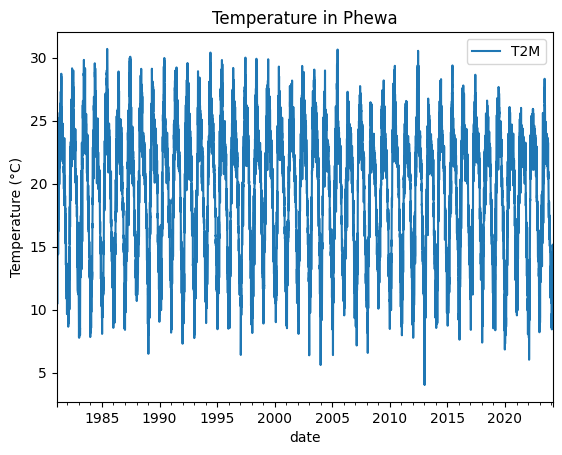

In [44]:
import matplotlib.pyplot as plt
df.plot()
plt.ylabel('Temperature (°C)')
_ = plt.title('Temperature in Phewa')

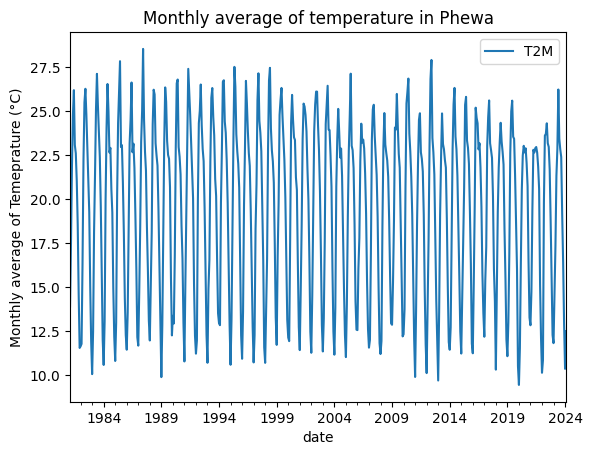

In [45]:
try:
    df_resampled_monthly = df.resample("ME")
except ValueError:
    # pandas < 2.2 uses M instead of ME
    df_resampled_monthly = df.resample("M")


df = df_resampled_monthly.mean().dropna(axis="index", how="any")
df.plot()
plt.ylabel("Monthly average of Temeprature (°C)")
_ = plt.title(
    "Monthly average of temperature in Phewa"
)

In [46]:
X = (df.index.year + df.index.month / 12).to_numpy().reshape(-1, 1)
y = df["T2M"].to_numpy()

### Design the proper kernem

In [47]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

In [48]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

In [49]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

In [50]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

In [51]:
temperature_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
temperature_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

### Model fitting and extrapolation

In [52]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=temperature_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

/Users/manish/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/manish/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/manish/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [53]:
import datetime

import numpy as np

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

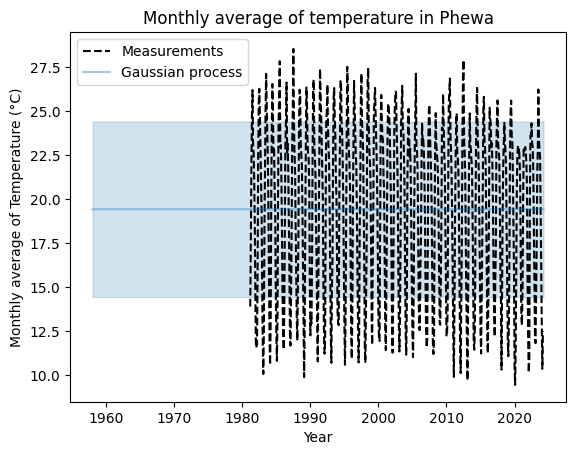

In [54]:
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of Temperature (°C)")
_ = plt.title(
    "Monthly average of temperature in Phewa"
)

In [55]:
gaussian_process.kernel_


0.00316**2 * RBF(length_scale=8.71e+04) + 0.626**2 * RBF(length_scale=1e-05) * ExpSineSquared(length_scale=1e-05, periodicity=1) + 0.00316**2 * RationalQuadratic(alpha=0.0199, length_scale=0.0133) + 0.0545**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=24.4)